**!!!! NOTE:** This notebook is much easier to navigate in Google Colab with the Table of Contents pane enabled.  To enable the Table of Contents pane, click 'View' (in this notebook's menu) and select 'Table of Contents'.  

Also note that (unlike jupyter notebooks) entire notebook sections can be "folded up" by clicking the down arrow next to the headers.  This makes browsing easier since it allows you to hide irrelevant/distracting bits of text and code.
___

In [0]:
config = { 
    'client_id':   'x3xkanz4izumcuymi3jyv84prz6i1b', 
    'client_secr': 'jf24lah20o6k53xs33s4qhn57dsflz'
  }

# `Auth` class


In [0]:
import requests


class Auth:
    def __init__(self, client_id, client_secr):
        self.client_id = client_id
        self.client_secr = client_secr
        self.__set_token()

    def __set_token(self):
        oauth_url = 'https://id.twitch.tv/oauth2/token'
        auth_params = {
            'client_id':      self.client_id,
            'client_secret':  self.client_secr,
            'grant_type':     'client_credentials'
            }
        with requests.post(oauth_url, data=auth_params) as req:
            self.auth_tok = req.json() 
            self.bear_tok = {
                'Authorization':  'Bearer ' + self.auth_tok['access_token'],
                'Client_ID':      self.client_id
                }


# `TwitchUser` Superclass

In [0]:
# from auth import Auth
import requests
import math
import pandas as pd


class TwitchUser:

    def __init__(self, auth: Auth, user_name: str, userid = None, sess = None):
        self._auth = auth

        if sess is not None:
          self.sess = sess
        else:
          self.sess = requests.Session()

        if userid is None:
          self.userid = get_userid(user_name)
        else:
          self.userid = userid

    def get_userid(username: str):
        # Check if defined before validating/assigning
        try:
            self.uid
            self.name
        except AttributeError:
            self.uid = None

        if self.uid is None and self.name is not None:
            uid_url = 'https://api.twitch.tv/helix/users'
            q_params = {'login': self.name}
            # TODO: add checks for HTTP response before assignment
            resp = self.sess.get(uid_url, params=q_params, headers=self._auth.bear_tok).json()

        else:
            uid = None
        # json response from twitch gives {data: []} for not found
        if len(resp['data']) > 0 and uid is not None:
          uid = resp['data'][0]['uid']

        return uid


    def _set_name(self, name:str):
        # Check if defined before validating/assigning
        try:
            self.name
        except AttributeError:
            if name is not none and name != "":
                self.name = str(name.lower())
            else:
                raise ValueError('Name must be defined and cannot be an empty string')


# I.) Authenticating with Twitch
A `client_id` was assigned to the Twitch developer account associated with this when it was first created on twitch.  A `client_id` should never change as long as the application remains registered with Twitch (i.e., is not removed/deleted from the [Twitch Developer Dashboard](https://dev.twitch.tv)).  

A secret client key was also provided for the `client_id` when this application was registered with Twitch.  If necessary, a new secret key can be requested from the Twitch Developer Dashboard.  However, a new secret key should seldom be neccessary (only if it is leaked or as a general security practice to retire/refresh old keys).

In [0]:
import requests
import json
import math
import pandas as pd

# The Client ID provided by twitch
CLIENT_ID = 'x3xkanz4izumcuymi3jyv84prz6i1b'

# The Client Secret provided by twitch
CLIENT_SECR = 'jf24lah20o6k53xs33s4qhn57dsflz'

# OAuth token retrieval 
auth_params = {
    'client_id':      CLIENT_ID,
    'client_secret':  CLIENT_SECR,
    'grant_type':     'client_credentials'
    }

oauth_url = 'https://id.twitch.tv/oauth2/token'
# Fetch Full Token, parse `access_token` for convenience
with requests.post(oauth_url, data=auth_params) as req:
  AUTH_TOK = req.json() 

# Although it's unclear whether the API is case-sensitive, note that `Client_ID` in
# the Bearer token is not identical to `client_id` supplied with the Authorization Token
BEAR_TOK = {
    'Authorization':  'Bearer ' + AUTH_TOK['access_token'],
    'Client_ID':      CLIENT_ID
}

#### **Rate Limiting** 
When `client_id` is supplied, the Twitch API limits to 30 "points" per minute.  When a bearer token is provided, this limit is raised to 800 "points" per minute.  These are not strictly requests/min or requests/second.  Instead, a [token bucket algorithm](https://en.wikipedia.org/wiki/Token_bucket) is used.  The Twitch API docs describe rate limiting is better detail.  The following chunk demonstrates how we can obtain information about our rate limit and how many tokens remain in our bucket before exhausting them.

From [**Rate Limits**](https://https://dev.twitch.tv/docs/api/guide#rate-limits) in the Twitch API documentation:
> **If this limit is exceeded, an error is returned: `HTTP 429 (Too Many Requests)`.**
When you make an API request, you will receive a set of rate-limiting headers to help your application respond appropriately. The headers are:
- `Ratelimit-Limit` — The rate at which points are added to your bucket. This is the average number of requests per minute you can make over an extended period of time.
- `Ratelimit-Remaining` — The number of points you have left to use.
- `Ratelimit-Reset` — A Unix epoch timestamp of when your bucket is reset to full.
<br><br>Individual endpoints may have additional rate limits, with additional headers to describe those limits. For details, see the documentation for each endpoint.<br><br>
Individual endpoints are given a point value. When an endpoint is called, the point value of the endpoint is subtracted from the total points granted to your client ID. The default point value is 1; i.e., a point is equivalent to a request. (All New Twitch API endpoints have the default point value. In the future, if an endpoint has a higher point value, that will be covered in the reference documentation for the endpoint.)<br><br>
If you need a higher rate limit, please fill out the form at https://dev.twitch.tv/limit-increase.

In [0]:
# Demo: Rate limiting & token buckets

# We can see how much of our alotted bucket we have used by examining
#  the headers returned by the HTTP server's response to our request

response = requests.get('https://api.twitch.tv/helix/users', 
                 params  = {'login': 'stroopc'}, 
                 headers = {'Client-ID': CLIENT_ID}
                 )

# This is the full header returned from Twitch -- Note the `ratelimit` related fields
dict(response.headers)

{'Connection': 'keep-alive',
 'Content-Length': '460',
 'Date': 'Wed, 04 Mar 2020 17:09:48 GMT',
 'Strict-Transport-Security': 'max-age=300',
 'Vary': 'Accept-Encoding',
 'X-Cache': 'MISS, MISS',
 'X-Cache-Hits': '0, 0',
 'X-Served-By': 'cache-sea4432-SEA, cache-hkg17934-HKG',
 'X-Timer': 'S1583341788.180299,VS0,VS0,VE147',
 'access-control-allow-origin': '*',
 'cache-control': 'no-cache, no-store, must-revalidate, private',
 'content-type': 'application/json; charset=utf-8',
 'expires': '0',
 'pragma': 'no-cache',
 'ratelimit-limit': '30',
 'ratelimit-remaining': '29',
 'ratelimit-reset': '1583341790',
 'server': 'envoy',
 'timing-allow-origin': 'https://www.twitch.tv',
 'twitch-trace-id': '8c72085000ddca99b24c7504918c0777',
 'x-ctxlog-logid': '1-5e5fe0dc-adecd16550949eb87c354d62'}

In [0]:
# Demo: Rate limiting & token buckets with back-to-back requests
def rate_lims():
  response = requests.get('https://api.twitch.tv/helix/users', 
                  params  = {'login': 'stroopc'}, 
                  headers = {'Client-ID': CLIENT_ID}
                  )
  return dict(response.headers)

# Query Twitch API twice, back-to-back to examine effect on ratelimit
runs = [rate_lims(), rate_lims()]
ratez = ['ratelimit-limit', 'ratelimit-remaining', 'ratelimit-reset']

# Display Results
for num in range(len(runs)):
  print("Run {}:".format(num+1))
  for rate in ratez:
    print("   {}: {}".format(rate, runs[num][rate]))

Run 1:
   ratelimit-limit: 30
   ratelimit-remaining: 28
   ratelimit-reset: 1583341792
Run 2:
   ratelimit-limit: 30
   ratelimit-remaining: 27
   ratelimit-reset: 1583341794


___
# II.) Followers Prototyping
**Note about the `requests` library and `Session()`**

These prototypes were built using the `requests` library in python.  Prior experimentation in early iterations of this notebook (not shown) demonstrated that using `requests.Session()` is substantially faster for repeated requests than simply using `requests.get()` alone.  Thus, it seems worthwhile to implement requests using `Sessions() ` (when possible): 

```
with requests.Session() as sess: 
  ses.get('url1')
  ses.get('url2')
```

Using `Session()` this way keeps the TCP connection alive for subsequent requests. Since `with ...` is used, the socket is closed when the block is completed (similar to how files are closed when using `with ...` to read them into a buffer).  However, it could also be used outside of `with ...` (though caution should probably be exercised to `sess.close()` an open sessions).
___


## `get_userid('username')` -- Fetch the `userid` associated with a given `username`
- Retrieves a `userid` associated with a `username` 
- A valid `userid` is required to fetch a followers list from twitch.
- Note that no `Session()` object is used in this implementation
- A valid `client_id` is required 
  This function was initially created for convenience but performing this action using `Sessions` results in shorter  times for large requests.



In [0]:
# Get userid for a given username
def get_userid(uname: str) -> str:
  base_url = 'https://api.twitch.tv/helix/users'
  query_params = {'login': uname.lower()}
  client_id = {'Client-ID': CLIENT_ID}
  with requests.get(base_url, params=query_params, headers=client_id) as req:
    uid = req.json()['data'][0]['id']
  return uid


# Demo of above function:
get_userid('stroopc')

'106071345'

#### *json format returned by Twitch*

In [0]:
# For Demonstration: the json object returned when requesting a `userid` from Twitch
def get_json_userid(uname: str) -> str:
  base_url = 'https://api.twitch.tv/helix/users'
  query_params = {'login': uname.lower()}
  client_id = {'Client-ID': CLIENT_ID}
  with requests.get(base_url, params=query_params, headers=client_id) as req:
    json_uid = req.json()
  return json_uid


# Demo of above function:
get_json_userid('stroopc')

{'data': [{'broadcaster_type': 'affiliate',
   'description': 'Getting into whatever these gaimz are',
   'display_name': 'stroopC',
   'id': '106071345',
   'login': 'stroopc',
   'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/697de25f-1da1-40ae-abe3-50895a1f18ea-channel_offline_image-1920x1080.png',
   'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/6e03c958-99ba-4073-beca-ea23efbc1457-profile_image-300x300.png',
   'type': '',
   'view_count': 10597}]}

In [0]:
foo = get_json_userid('stradfafadfasfasdfsafasdfasfeoopc')

In [0]:
len(foo['data'])

0

___
##`get_followers('username')` -- return a `df` of all Followers for a given `username`

**THIS FUNCTION HAS BEEN DEPRECATED**

This function calls `get_userid('username')` before fetching a list of followers associated with the supplied `username`.
For the purposes of this notebook, the following function builds a dataframe from a requested json payload.  This `df` conversion isn't necessarily intended for use in production.  Also shown here is the benefit of leveraging the `Sessions` functionality of the `requests` library.

- Note: this was an early prototype
 - Later replaced by `get_followings` because:
   - `get_followings` provided a way to specify whether we want followers **of** a streamer or the *followings* for any user (*followings* = who does some user follow)
   - originally, this function did not implement a `Sessions` object as a parameter when called (though `get_followings()` *does* accept a `Sessions` object)
- Note: Twitch returns the most recent followers first


In [0]:
# THIS FUNCTION IS DEPRECATED -- USE get_followings INSTEAD
# The following keys are provided from req.json():  'total', 'data', 'pagination'
def get_followers(username: str):
  uid_url  = 'https://api.twitch.tv/helix/users'
  base_url = 'https://api.twitch.tv/helix/users/follows'

  with requests.Session() as sess:
    # Fetch UserID associated with username
    q_params = {'login': username.lower()}
    client_id = {'Client-ID': CLIENT_ID}
    user = sess.get(uid_url, params=q_params, headers=client_id).json()
    uid  = user['data'][0]['id']

    # Set query parameters passed to followers request
    q_params = {'to_id': uid, 'first': 100}

    # Fetch Initial Followers Data
    req  = sess.get(base_url, params=q_params, headers=client_id)
    resp = req.json()

    # Add cursor value to query params dict
    q_params['after'] = resp['pagination']['cursor']

    # Create a pandas dataframe from the json payload
    followers_df = pd.DataFrame(resp['data'])
    
    # Loop until no followers left to gather
    tot_fol = resp['total']   
    for i in range(math.floor(tot_fol/100)):
      resp              = sess.get(base_url, params=q_params, headers=BEAR_TOK).json()
      followers_df      = followers_df.append(resp['data'], ignore_index=True)
      q_params['after'] = resp['pagination']['cursor']

  return followers_df

In [0]:
%%time
# Time to get using SESSIONS without get_userid helper
get_followers('stroopc')

CPU times: user 34 ms, sys: 693 µs, total: 34.7 ms
Wall time: 1.17 s


,from_id,from_name,to_id,to_name,followed_at
0,402754722,soldierplaysfortnite,106071345,stroopC,2020-02-16T05:31:47Z
1,482141011,xvxaltxr,106071345,stroopC,2020-02-15T06:04:38Z
2,486992199,fashonshowjordankong21,106071345,stroopC,2020-02-15T05:14:05Z
3,487555305,monkey_zshadow,106071345,stroopC,2020-02-14T05:59:16Z
4,177726472,Footbucket,106071345,stroopC,2020-02-13T04:55:10Z
...,...,...,...,...,...
460,102461035,tunaprimo,106071345,stroopC,2018-08-14T14:10:56Z
461,63206996,humerusj,106071345,stroopC,2018-08-12T21:37:25Z
462,247066768,2mikeman,106071345,stroopC,2018-08-11T08:00:10Z
463,36986060,stroopG,106071345,stroopC,2018-08-02T00:26:08Z


#### *json format returned by Twitch* (5 most recent followers)
The number of followers we wish to retrieve is specfied by `first` in the query parameters dictionary (`q_params`).  The maximum per request is 100.

In [0]:
# This function demonstrates the json format of followers returned by Twitch for 
def get_json_followers(username: str):
  uid_url  = 'https://api.twitch.tv/helix/users'
  base_url = 'https://api.twitch.tv/helix/users/follows'

  with requests.Session() as sess:
    # Fetch UserID associated with username (get_userid() is omitted)
    q_params = {'login': username.lower()}
    client_id = {'Client-ID': CLIENT_ID}
    user = sess.get(uid_url, params=q_params, headers=client_id).json()
    uid  = user['data'][0]['id']

    # Set query parameters passed to followers request - only request 5
    q_params = {'to_id': uid, 'first': 5}

    # Fetch Initial Followers Data
    req  = sess.get(base_url, params=q_params, headers=client_id)
    resp = req.json()

  #return json.dumps(resp, indent = 4, sort_keys=True)
  return resp


# Demo of above function
json_fols = get_json_followers('stroopc')
json_fols
  

{'data': [{'followed_at': '2020-02-16T05:31:47Z',
   'from_id': '402754722',
   'from_name': 'soldierplaysfortnite',
   'to_id': '106071345',
   'to_name': 'stroopC'},
  {'followed_at': '2020-02-15T06:04:38Z',
   'from_id': '482141011',
   'from_name': 'xvxaltxr',
   'to_id': '106071345',
   'to_name': 'stroopC'},
  {'followed_at': '2020-02-15T05:14:05Z',
   'from_id': '486992199',
   'from_name': 'fashonshowjordankong21',
   'to_id': '106071345',
   'to_name': 'stroopC'},
  {'followed_at': '2020-02-14T05:59:16Z',
   'from_id': '487555305',
   'from_name': 'monkey_zshadow',
   'to_id': '106071345',
   'to_name': 'stroopC'},
  {'followed_at': '2020-02-13T04:55:10Z',
   'from_id': '177726472',
   'from_name': 'Footbucket',
   'to_id': '106071345',
   'to_name': 'stroopC'}],
 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjp7IkN1cnNvciI6IjE1ODE1Njk3MTA0OTA1NTk0NDEifX0'},
 'total': 465}

In [0]:
json_fols['data']

[{'followed_at': '2020-02-16T05:31:47Z',
  'from_id': '402754722',
  'from_name': 'soldierplaysfortnite',
  'to_id': '106071345',
  'to_name': 'stroopC'},
 {'followed_at': '2020-02-15T06:04:38Z',
  'from_id': '482141011',
  'from_name': 'xvxaltxr',
  'to_id': '106071345',
  'to_name': 'stroopC'},
 {'followed_at': '2020-02-15T05:14:05Z',
  'from_id': '486992199',
  'from_name': 'fashonshowjordankong21',
  'to_id': '106071345',
  'to_name': 'stroopC'},
 {'followed_at': '2020-02-14T05:59:16Z',
  'from_id': '487555305',
  'from_name': 'monkey_zshadow',
  'to_id': '106071345',
  'to_name': 'stroopC'},
 {'followed_at': '2020-02-13T04:55:10Z',
  'from_id': '177726472',
  'from_name': 'Footbucket',
  'to_id': '106071345',
  'to_name': 'stroopC'}]

___
## `get_followings('userid', 'to_or_from')`
- Replaces `get_followers()`
- if `'to'` is given then this function returns a dataframe of people who *are following* a streamer
- if `'from'` is given then this function returns a dataframe of streams that a user follows (their *followings*)
- this functionality allows `get_follnet` to collect a streamers followers and the followings of those followers





In [0]:
#TODO: IMPLEMENT UPPERBOUND CHECK FOR TOT_FOL
'''
This function returns a dictionary containing a dataframe and a session object.
The dataframe contains followings (either to or from) for the specified userid.

The total number of followings is returned in the json response from the initial query.
This total is used for looping and appending to the dataframe to be returned.

Sess is passed around and returned to maintain the current session for subsequent calls.
'''
def get_followings(uid: str, to_from='to_id', sess=None):
  # Create a Session object if it was not supplied
  if sess is None:
    sess = requests.Session()

  # Initial Query: followers for given userid
  base_url = 'https://api.twitch.tv/helix/users/follows'
  q_params = {to_from: uid, 'first': 100}
  resp = sess.get(base_url, params=q_params, headers=BEAR_TOK).json()
 
  # Create a pandas dataframe from the json response
  foll_df = pd.DataFrame(resp['data'])

  # Add cursor val to query params dict
  q_params['after'] = resp['pagination']['cursor']

  # Append to df until no followings remain
  reported_fols = resp['total']
  num_remaining = reported_fols - 100  # subtract 100 since we burned it on the first query

  while num_remaining > 0: 
    resp    = sess.get(base_url, params=q_params, headers=BEAR_TOK).json()
    foll_df = foll_df.append(resp['data'], ignore_index=True)
    q_params['after'] = resp['pagination']['cursor']
    num_remaining -= 100

  return {'total_reported': reported_fols, 'df': foll_df}, sess

In [0]:
# Demo of get_followings
get_followings(get_userid('stroopc'))

({'df':        from_id         from_name      to_id  to_name           followed_at
  0    424606673         TST_Logan  106071345  stroopC  2020-01-26T07:42:56Z
  1    458875203        wowigorl08  106071345  stroopC  2020-01-20T08:42:19Z
  2    486896030    suck_a_fat_one  106071345  stroopC  2020-01-20T07:27:51Z
  3    484573087  ciscogonzalez559  106071345  stroopC  2020-01-20T06:43:46Z
  4    457857594        goomytanyt  106071345  stroopC  2020-01-16T06:01:20Z
  ..         ...               ...        ...      ...                   ...
  450  102461035         tunaprimo  106071345  stroopC  2018-08-14T14:10:56Z
  451   63206996          humerusj  106071345  stroopC  2018-08-12T21:37:25Z
  452  247066768          2mikeman  106071345  stroopC  2018-08-11T08:00:10Z
  453   36986060           stroopG  106071345  stroopC  2018-08-02T00:26:08Z
  454  154995746      StormIsZaddy  106071345  stroopC  2018-06-08T00:45:21Z
  
  [455 rows x 5 columns], 'total_reported': 455},
 <requests.sessio

___

## `get_follnet('streamer_name')`
This function uses `get_followings` to fetch a dataframe of a streamers followers.  From the list of userids following a streamer, a follower network is built by querying each of the streamers followers to determine followings.


In [0]:
# Gets the full 2-level follower network for a streamer
def get_follnet(streamer_name: str):
  with requests.Session() as sess:
    # Fetch UserID associated with username
    uid_url = 'https://api.twitch.tv/helix/users'
    q_params = {'login': streamer_name.lower()}
    user = sess.get(uid_url, params=q_params, headers=BEAR_TOK).json()
    strmr_id  = user['data'][0]['id']

    # Get df and list of follower ids about who follows streamer
    to_from = {'to': 'to_id', 'from': 'from_id'}
    results_streamer, sess = get_followings(strmr_id, to_from['to'], sess)
    uid_list = results_streamer['df']['from_id'].values.tolist()

    # Curious to know more about a 'typical' number of followings
    # fastest way of getting numrows of df:  df[0].count()

    # Get who followers follow (for given streamer) as a list of df -- switch to df.append after testing here
    #df_followings = pd.DataFrame(columns=['from_id', 'from_name', 'to_id', 'to_name', 'followed_at'])
    df_followings = pd.DataFrame()

    num_followings = []
    for foll_id in uid_list:
      foll_results, sess = get_followings(foll_id, to_from['from'], sess)
      tmp_df = foll_results['df']
      df_followings = df_followings.append(tmp_df, ignore_index=True) # <-- why doesn't this work
      
      #import pdb; pdb.set_trace()

      foll_tot = foll_results['total_reported']
      num_followings.append(foll_tot)

    result = {'stream_folls': results_streamer,
              'followings': df_followings,
              'tot_followings': num_followings
              }
    
    return result

In [0]:
%%time
# Test get_follnet
follower_network = get_follnet('stroopc')

CPU times: user 7.49 s, sys: 224 ms, total: 7.71 s
Wall time: 3min 52s


___
# III.) Inspection/Analysis of A Follower Network

This section digs into the results of a follower network to allow us to gain some insight about a follower network and inform design decisions in later stages.

In [0]:
follower_network['followings']

,from_id,from_name,to_id,to_name,followed_at
0,481208927,teusking0,118765330,canaldopang,2020-01-28T07:35:22Z
1,481208927,teusking0,467590374,sweetwutang,2020-01-28T07:29:02Z
2,481208927,teusking0,479020895,vanthirteen,2020-01-28T07:28:09Z
3,481208927,teusking0,186123851,ailuro5,2020-01-28T07:27:18Z
4,481208927,teusking0,184995069,KellyWarp,2020-01-28T07:26:12Z
...,...,...,...,...,...
83103,154995746,StormIsZaddy,106071345,stroopC,2018-06-08T00:45:21Z
83104,154995746,StormIsZaddy,29829912,DrLupo,2018-05-05T20:25:42Z
83105,154995746,StormIsZaddy,19571641,Ninja,2018-03-08T04:19:41Z
83106,154995746,StormIsZaddy,41858064,DarkZekrom9898,2017-12-14T06:09:44Z


In [0]:
# This is clunky but worked in a pinch
df_val_counts = pd.DataFrame(pd.Index(follower_network['followings'].to_name).value_counts()).reset_index() ; df_val_counts
df_val_counts.columns = ['stream', 'counts']

# FINALLY 
foll_net_counts = df_val_counts.drop(0, axis=0)
foll_net_counts

,stream,counts
1,Tfue,192
2,Ninja,187
3,Myth,152
4,TSM_Daequan,133
5,SypherPK,125
...,...,...
57874,drexxfn,1
57875,LuckyxMoon,1
57876,R4ND1,1
57877,af047,1


In [0]:
foll_net_counts.describe()

,counts
count,57875.000000
mean,1.427940
std,2.807943
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,192.000000


When we see count of 1, this indicates that there is no overlap.  Thus, we want to exclude counts of 1 since it is not useful for finding overlapping streams.

In [0]:
df_not_1 = foll_net_counts[foll_net_counts['counts'] > 1] ; df_not_1

,stream,counts
1,Tfue,192
2,Ninja,187
3,Myth,152
4,TSM_Daequan,133
5,SypherPK,125
...,...,...
9514,ih0st,2
9515,WhiteBoy7thst,2
9516,xSlickzTp,2
9517,levinh_,2


Note how many rows were eliminated:  we went from 57,875 rows in the initial scrape down to 9518 rows after eliminating non-overlapping followings.


In [0]:
df_not_1.describe()

,counts
count,9518.000000
mean,3.602122
std,6.502982
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,192.000000


(array([5473., 1714.,  846.,    0.,  464.,  326.,    0.,  202.,  132.,
          90.]),
 array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]),
 <a list of 10 Patch objects>)

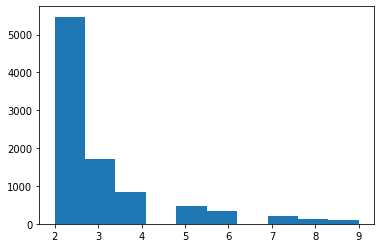

In [0]:
import matplotlib.pyplot as plt
some_upperbd = 10
df_less_than = df_not_1[df_not_1['counts'] < some_upperbd]
plt.hist(df_less_than['counts'])

## Want to know: how many streamers do viewers typically follow
- we need this to set an upperbound before retrieving a viewers followings
- this is also necessary/useful for optimizing a `follnet` scrape
 - That is, after scraping `get_followers()` of a streamer, we can check how many people each follower is following 


___
# Interesting or Potentially Useful Chunks
The code chunks in this section *might* not be used anywhere else in the notebook.  These chunks were created when reading API documentation and experimenting with features.  They are kept around because they demonstrate what content is served by the twitch api from a request or because these chunks *could* be useful later (either in themselves or as a piece for acheiving a larger objective).  They also exist to serve as "reminders" of things that have been encountered when browsing documentation.



### `get_chatters('username')` -- Fetch the live state of chatters in a channel 
- This function gets the current live state chatters in a broadcaster's room (sometimes referred to as a "channel") on twitch.
- This function does not necessarily indicate whether the supplied channel is currently live.  
 - That is, a broadcaster can be in their own chat room without necessarily being live (for example, they may be modifying bot commands).
 - Thus, the function is appropriately named `get_chatters`

- Note that no credentials were required to obtain the state of a room (no client id or auth key is used).



In [0]:
# Fetch a list of live chatters in a supplied username's channel, returned here in json format
def get_chatters(username: str) -> dict:
  base_url = "https://tmi.twitch.tv/group/user/" + username.lower() + "/chatters"
  return requests.get(base_url).json()

In [0]:
# Demo of `get_chatters()` - a json string is returned (and formatted)
demo = json.dumps(get_chatters('xypherorion'), indent = 4, sort_keys=True)
print(demo)

# Pandas can easily transform json format into a DataFrame:
pd.DataFrame(get_chatters('xypherorion'))

{
    "_links": {},
    "chatter_count": 14,
    "chatters": {
        "admins": [],
        "broadcaster": [
            "xypherorion"
        ],
        "global_mods": [],
        "moderators": [
            "henchperson",
            "lithaya",
            "nightbot"
        ],
        "staff": [],
        "viewers": [
            "alfredjudokus100289",
            "astarbreeze",
            "chatswithrad",
            "commanderroot",
            "corben78",
            "lucaslpa2000",
            "ravendarq",
            "winsock"
        ],
        "vips": [
            "lyfesaver74",
            "tiddyvrlive"
        ]
    }
}


,_links,chatter_count,chatters
broadcaster,NaN,14,[xypherorion]
vips,NaN,14,"[lyfesaver74, tiddyvrlive]"
moderators,NaN,14,"[henchperson, lithaya, nightbot]"
staff,NaN,14,[]
admins,NaN,14,[]
global_mods,NaN,14,[]
viewers,NaN,14,"[alfredjudokus100289, astarbreeze, chatswithra..."


---
# Miscellaneous


In [0]:
def getChannelInfo(id):
    headers = {
	"Accept": "application/vnd.twitchtv.v5+json",
	"Client-ID": 'x3xkanz4izumcuymi3jyv84prz6i1b'
}

    url = "https://api.twitch.tv/kraken/channels/" + str(id)
    r = requests.get(url, headers=headers)

    return r.json()
    return {
        "twitch_id": response["_id"],
        "name": response["name"],
        "follower_count": response["followers"]
    }

getChannelInfo(106071345)

{'_id': '106071345',
 'broadcaster_language': 'en',
 'broadcaster_software': 'unknown_rtmp',
 'broadcaster_type': 'affiliate',
 'created_at': '2015-11-04T02:31:54Z',
 'description': 'Getting into whatever these gaimz are',
 'display_name': 'stroopC',
 'followers': 465,
 'game': 'Science & Technology',
 'language': 'en',
 'logo': 'https://static-cdn.jtvnw.net/jtv_user_pictures/6e03c958-99ba-4073-beca-ea23efbc1457-profile_image-300x300.png',
 'mature': True,
 'name': 'stroopc',
 'partner': False,
 'privacy_options_enabled': False,
 'private_video': False,
 'profile_banner': 'https://static-cdn.jtvnw.net/jtv_user_pictures/38724ea6-78b9-4d7b-8b8d-85c68e4a9a44-profile_banner-480.jpeg',
 'profile_banner_background_color': None,
 'status': "O SHOOT IT'S DAT BOIIIII",
 'updated_at': '2020-03-03T09:09:47Z',
 'url': 'https://www.twitch.tv/stroopc',
 'video_banner': 'https://static-cdn.jtvnw.net/jtv_user_pictures/697de25f-1da1-40ae-abe3-50895a1f18ea-channel_offline_image-1920x1080.png',
 'views':